In [1]:
import tensorflow_probability as tfp
tfd = tfp.distributions
import pandas as pd
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
import numpy as np
from scipy import stats

In [2]:
# Load the California Housing dataset
housing = fetch_california_housing(as_frame=True)


df = pd.DataFrame(data=housing.data, columns=housing.feature_names)
df["target"] = housing.target

df = df[(np.abs(stats.zscore(df)) < 5).all(axis=1)]
df = df.reset_index(drop=True)
X = df[housing.feature_names]
targets = df["target"]
# Always use transform_data function on X
scaler = StandardScaler().fit(np.array(targets).reshape(-1, 1))
targets = scaler.transform(np.array(targets).reshape(-1, 1)).flatten()

df["target"] = targets
data=df

In [3]:
import sys
sys.path.append('..')
from xDL.models.NAMLSS import NAMLSS

In [4]:
namlss = NAMLSS(
    "target ~  -1 + MLP(MedInc) + MLP(AveOccup) + MLP(AveBedrms)+ MLP(Population)+  MLP(Latitude):MLP(Longitude) + MLP(AveRooms)", 
    data=data, 
    family="Normal", 
    feature_dropout=0.0001
    )


In [5]:
namlss.feature_nets[0].summary()

Model: "MedInc"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MedInc (InputLayer)         [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 128)               256       
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 2)                 64        
                                                                 
Total params: 10656 (41.62 KB)
Trainable params: 10656 (41.6

In [6]:
def KL_Divergence(y_true, y_hat):
    t = tfd.Normal(loc=y_true, scale=tf.math.reduce_std(y_true))
    p = tfd.Normal(loc=y_hat, scale=tf.math.reduce_std(y_true))  
    kl = tf.reduce_mean(tfd.kl_divergence(t, p, allow_nan_stats=True))
    return kl

namlss.compile(
    optimizer=Adam(learning_rate=0.001), 
    loss=namlss.NegativeLogLikelihood, 
    metrics=KL_Divergence
    )

# Train the model
namlss.fit(namlss.training_dataset, epochs=100, validation_data=namlss.validation_dataset)

# Evaluate the model
loss = namlss.evaluate(namlss.validation_dataset)
print("Test Loss:", loss)

Epoch 1/100


16/16 [==============================] - 7s 54ms/step - loss: 1.3398 - KL_Divergence: 0.9480 - val_loss: 1.0936 - val_KL_Divergence: 0.6277
Epoch 2/100
16/16 [==============================] - 1s 35ms/step - loss: 1.0432 - KL_Divergence: 0.5290 - val_loss: 0.8843 - val_KL_Divergence: 0.4337
Epoch 3/100
16/16 [==============================] - 1s 33ms/step - loss: 0.8933 - KL_Divergence: 0.3968 - val_loss: 0.7936 - val_KL_Divergence: 0.3837
Epoch 4/100
16/16 [==============================] - 1s 35ms/step - loss: 0.8290 - KL_Divergence: 0.3727 - val_loss: 0.7232 - val_KL_Divergence: 0.3140
Epoch 5/100
16/16 [==============================] - 1s 30ms/step - loss: 0.7807 - KL_Divergence: 0.3522 - val_loss: 0.7234 - val_KL_Divergence: 0.3367
Epoch 6/100
16/16 [==============================] - 1s 29ms/step - loss: 0.7580 - KL_Divergence: 0.3383 - val_loss: 0.6720 - val_KL_Divergence: 0.3232
Epoch 7/100
16/16 [==============================] - 1s 27ms/step - loss: 0.7323 - KL_Divergence: 0.

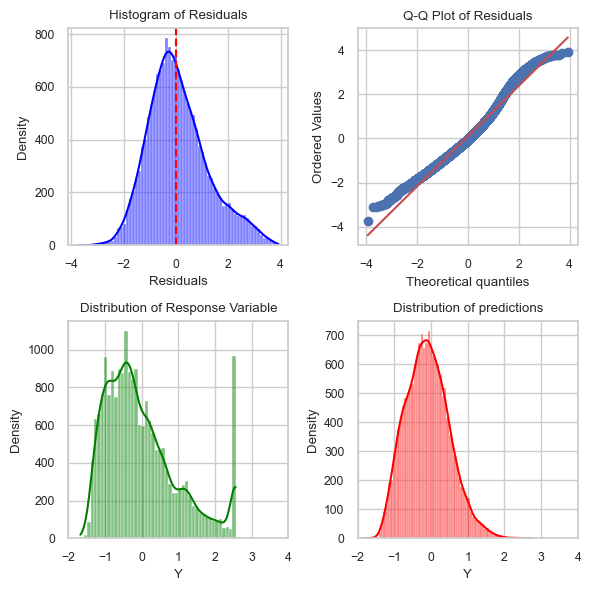

In [7]:
namlss.analytics_plot()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


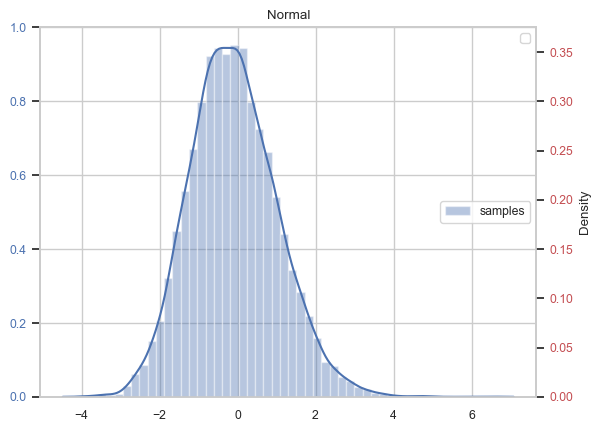

In [8]:
namlss.plot_dist()

In [9]:
namlss.feature_nets[1].predict(namlss.training_dataset)[:,1]

16/16 [==============================] - 0s 8ms/step


array([-0.15608586,  0.0440856 ,  0.05575595, ..., -0.0957557 ,
       -0.1186485 , -0.16428457], dtype=float32)

100/100 [==============================] - 0s 2ms/step


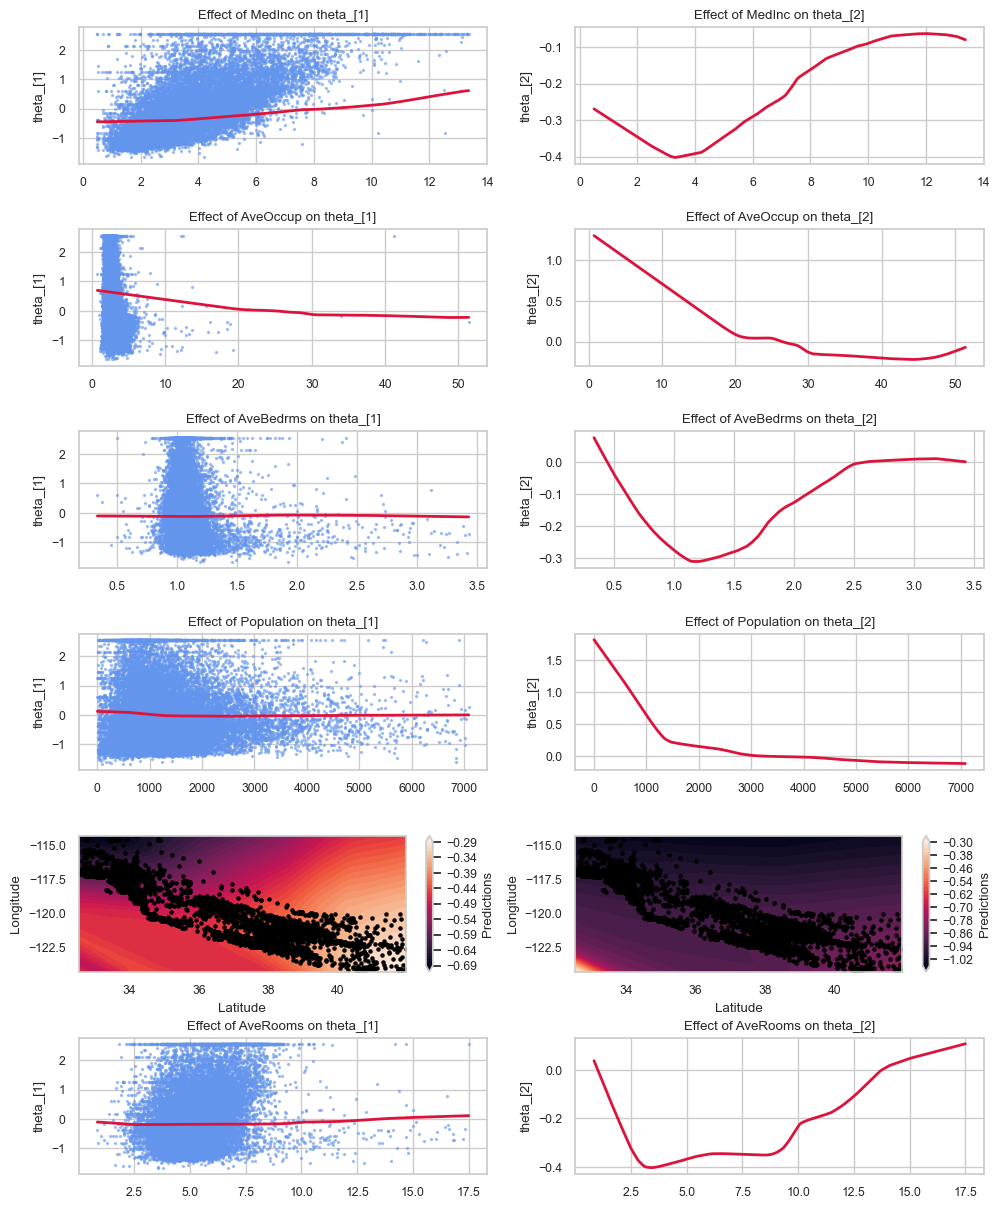

In [10]:
namlss.plot()